In [1]:
from re import sub
from decimal import Decimal
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc("figure", dpi=100)
import numpy as np
import re
import pandas as pd
import seaborn as sns
sns.set_style("ticks")

In [2]:


class RoverSettings():
    def __init__(self, zip_code):

        self.repeat_client_class = "CalloutBadge__Badge-rduqlb-0 iuzSam InfoPills__StyledCalloutBadge-sc-1jou7n9-4 jHASEn"
        self.price_class = "PriceAndFavoriteColumn__Price-sc-5y9bmw-3 hYSwMH"
        self.sitter_class = "VerticalLayout-sc-31y83h-0 SearchResultCard__SearchResultCardWrapper-sc-186pa8o-1 csDLKS bsrZxg"
        self.name_class = "NameRow__StyledNameAndBadge-t135c7-1 iecWGG"
        self.sitter_location_class = "InfoColumn__Location-qduboa-2 gJTzwa"

        self.zip_code = zip_code

        self.zip_coords = pd.read_csv(
            "https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data")
        self.coords = self.zip_coords[self.zip_coords['ZIP'] == zip_code]
        self.LAT = float(self.coords['LAT'].values)
        self.LON = float(self.coords['LNG'].values)

        self.num_pages = 50


class Sitter():
    def __init__(self):
        self.price = None
        self.repeating_customers = None
        self.name = None
        self.location = None


zip_code = 10029
settings = RoverSettings(zip_code)


start_date = '05%2F14%2F2022'
end_date = '05%2F15%2F2022'


# most similar to us
url = "https://www.rover.com/search/?alternate_results=true&override_check=true&accepts_only_one_client=false&apse=false&bathing_grooming=false&cat_care=false&centerlat={1}&centerlng={2}&dogs_allowed_on_bed=true&dogs_allowed_on_furniture=true&end_date={4}&frequency=onetime&morning_availability=false&midday_availability=false&evening_availability=false&fulltime_availability=true&giant_dogs=false&has_fenced_yard=true&has_house=false&has_no_children=false&is_premier=false&knows_first_aid=false&large_dogs=false&location={4}&location_accuracy=1000&maxprice=150&medium_dogs=true&minprice=1&no_caged_pets=false&no_cats=false&no_children_0_5=false&no_children_6_12=false&non_smoking=true&page={0}&person_does_not_have_dogs=true&pet=&petsitusa=false&pet_type=dog&puppy=false&service_type=overnight-boarding&small_dogs=true&spaces_required=1&start_date={3}&search_score_debug=false&injected_medication=false&special_needs=false&oral_medication=false&more_than_one_client=false&uncrated_dogs=false&unspayed_females=false&non_neutered_males=false&females_in_heat=false&unactivated_provider=false&premier_matching=false&premier_or_rover_match=false&is_member_of_sitter_to_sitter=false&is_member_of_sitter_to_sitter_plus=false&location_type=zip-code&raw_location_types=postal_code&dog_size=small,medium"

# no downselection
#url = "https://www.rover.com/search/?alternate_results=true&override_check=true&accepts_only_one_client=false&apse=false&bathing_grooming=false&cat_care=false&centerlat=40.79164069999999&centerlng=-73.9447994&dogs_allowed_on_bed=false&dogs_allowed_on_furniture=false&end_date=04%2F23%2F2022&frequency=onetime&morning_availability=false&midday_availability=false&evening_availability=false&fulltime_availability=true&giant_dogs=false&has_fenced_yard=false&has_house=false&has_no_children=false&is_premier=false&knows_first_aid=false&large_dogs=false&location=10029&location_accuracy=5161&medium_dogs=false&minprice=0&no_caged_pets=false&no_cats=false&no_children_0_5=false&no_children_6_12=false&non_smoking=false&page={0}&person_does_not_have_dogs=false&pet=&petsitusa=false&pet_type=dog&puppy=false&service_type=overnight-boarding&small_dogs=false&spaces_required=1&start_date=04%2F18%2F2022&search_score_debug=false&injected_medication=false&special_needs=false&oral_medication=false&more_than_one_client=false&uncrated_dogs=false&unspayed_females=false&non_neutered_males=false&females_in_heat=false&unactivated_provider=false&premier_matching=false&premier_or_rover_match=false&is_member_of_sitter_to_sitter=false&is_member_of_sitter_to_sitter_plus=false&location_type=zip-code&raw_location_types=postal_code"

# least possible inputs
#url = "https://www.rover.com/search/?alternate_results=true&override_check=true&centerlat={1}&centerlng={2}&frequency=onetime&location={5}&location_type=zip-code&pet=&pet_type=dog&raw_location_types=postal_code&service_type=overnight-boarding&page={0}&start_date={3}&end_date={4}"


In [3]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager

options = Options()
options.add_argument('--headless')

driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()),options=options)
driver.get("https://www.google.com")
print('Done')
driver.quit()



====== WebDriver manager ======
Current firefox version is 99.0
Get LATEST geckodriver version for 99.0 firefox
Getting latest mozilla release info for v0.31.0
Trying to download new driver from https://github.com/mozilla/geckodriver/releases/download/v0.31.0/geckodriver-v0.31.0-win64.zip
Driver has been saved in cache [C:\Users\pkastner\.wdm\drivers\geckodriver\win64\v0.31.0]


Done


In [4]:
def get_sitters(i, sitter_divs, settings):

    s = Sitter()

    name_string = str(sitter_divs[i].find(
        "div", {"class": settings.name_class}).text).replace('\xa0', '')
    s.name = name_string

    price_string = sitter_divs[i].find(
        "div", {"class": settings.price_class}).string

    s.price = float(Decimal(sub(r'[^\d.]', '', price_string)))

    try:
        repeated_clients_string = sitter_divs[i].find(
            "span", {"class": settings.repeat_client_class}).string
        if str.endswith(repeated_clients_string, 'repeat clients'):
            rc = int(re.findall(r'\d+', repeated_clients_string)[0])
            s.repeating_customers = rc
    except:
        s.repeating_customers = 0

    print(s.name, s.price, s.repeating_customers)

    return s





====== WebDriver manager ======
Current firefox version is 99.0
Get LATEST geckodriver version for 99.0 firefox
Driver [C:\Users\pkastner\.wdm\drivers\geckodriver\win64\v0.31.0\geckodriver.exe] found in cache
test_get_url (__main__.TestNotebook) ... ERROR

ERROR: test_get_url (__main__.TestNotebook)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\pkastner\AppData\Local\Temp/ipykernel_30956/3306885718.py", line 40, in test_get_url
    s = get_sitters(i, sitter_divs, settings)
NameError: name 'get_sitters' is not defined

----------------------------------------------------------------------
Ran 1 test in 2.002s

FAILED (errors=1)


In [13]:

import unittest

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager

options = Options()
options.add_argument('--headless')

driver = webdriver.Firefox(service=Service(
    GeckoDriverManager().install()), options=options)


class TestNotebook(unittest.TestCase):

    def test_get_url(self):

        zip_code = 10029
        settings = RoverSettings(zip_code)

        sitters = []

        start_date = '05%2F14%2F2022'
        end_date = '05%2F15%2F2022'

        driver.get(url.format(1, settings.LAT, settings.LON,
                   start_date, end_date, zip_code))

        html = driver.page_source
        page_html = BeautifulSoup(html)

        sitter_divs = page_html.find_all(
            "div", {"class": settings.sitter_class})

        for i, sitter in enumerate(sitter_divs):

            s = get_sitters(i, sitter_divs, settings)

            sitters.append(s)

        self.assertEqual(len(sitters), 20)


unittest.main(argv=[''], verbosity=2, exit=False)





====== WebDriver manager ======
Current firefox version is 99.0
Get LATEST geckodriver version for 99.0 firefox
Driver [C:\Users\pkastner\.wdm\drivers\geckodriver\win64\v0.31.0\geckodriver.exe] found in cache
test_get_url (__main__.TestNotebook) ... 

Josie 100.0 3
Nicolas 88.0 2
Stephanie 39.0 13
Eric 50.0 4
Jenny 100.0 13
Stephanie 50.0 None
Jessica 45.0 None
Shalaila 60.0 2
David 60.0 6
Ariel 40.0 None
Taylor 63.0 21
A 55.0 8
Marilyn 70.0 13
Debra 60.0 41
Ryan 100.0 2
Chi-Wing 40.0 None
Etrita 65.0 5
Gretchen & Chris 50.0 None
Alexandra 50.0 None
Freda 80.0 2


ok

----------------------------------------------------------------------
Ran 1 test in 1.912s

OK


In [7]:
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager

options = Options()
options.add_argument('--headless')

driver = webdriver.Firefox(service=Service(
    GeckoDriverManager().install()), options=options)


sitters = []

for page in range(1, settings.num_pages):

    driver.get(url.format(page, settings.LAT, settings.LON,
               start_date, end_date, zip_code))

    html = driver.page_source
    page_html = BeautifulSoup(html)

    sitter_divs = page_html.find_all("div", {"class": settings.sitter_class})

    for i, sitter in enumerate(sitter_divs):

        s = get_sitters(i, sitter_divs, settings)

        sitters.append(s)




====== WebDriver manager ======
Current firefox version is 99.0
Get LATEST geckodriver version for 99.0 firefox
Driver [C:\Users\pkastner\.wdm\drivers\geckodriver\win64\v0.31.0\geckodriver.exe] found in cache


Stephanie 39.0 13
Josie 100.0 3
Nicolas 88.0 2
Eric 50.0 4
Jessica 45.0 None
Stephanie 50.0 None
Jenny 100.0 13
Tien & Christine 75.0 None
Sparkle 45.0 None
Freda 80.0 2
Ariel 40.0 None
Alexandra 50.0 None
A 55.0 8
David 60.0 6
Taylor 63.0 21
Shruti 40.0 None
Debra 60.0 41
Shalaila 60.0 2
Edicson 40.0 2
Amy 38.0 3
Melissa 65.0 44
Ryan 100.0 2
Wanda 65.0 None
Chi-Wing 40.0 None
Maria 48.0 3
Etrita 65.0 5
Sid 65.0 79
Annie 36.0 3
Gretchen & Chris 50.0 None
Ashley 89.0 54
Summer 50.0 7
Alan 50.0 4
Marilyn 70.0 13
Tsering 150.0 15
Ellie 80.0 8
Brandii 60.0 16
Hisham 45.0 None
Joseline 94.0 None
Valerie 90.0 17
Rosemeri A. 55.0 9
Lindsay 60.0 150
Dale 45.0 17
Cristina 45.0 None
Isalina 46.0 None
Hannibal & Carla 55.0 107
Charlotte 70.0 None
Juan Francisco 150.0 9
Sophie 86.0 68
Ahmed 46.0 26
Anne-Marie 65.0 None
Maddy 55.0 6
Sangah 40.0 None
Juliette 50.0 4
Michelle 40.0 4
Jessica 40.0 56
Sasha 60.0 19
Alexandra 100.0 0
Alexis 70.0 18
Jojo 58.0 22
Anna 80.0 32
Heather 85.0 31
Yuraika 38.0 8

In [10]:
keys_in_class = vars(sitters[0]).keys()

df = pd.DataFrame([[getattr(i,j) for j in keys_in_class] for i in sitters], columns = keys_in_class)
df = df.drop_duplicates()

df.to_csv("results.csv", index=False)

filtered = df.loc[(df['repeating_customers'] > 1) & (df['repeating_customers'] < 125 ) & (df['price'] < 150 ) ]

filtered.sort_values(by=['repeating_customers']).to_csv("repeating_customers_"+str(zip_code)+".csv")
filtered.sort_values(by=['repeating_customers'])

,price,repeating_customers,name,location
68,65.0,2.0,Buse,None
182,65.0,2.0,Elizabeta,None
104,40.0,2.0,Nikki,None
356,44.0,2.0,Ileana,None
355,100.0,2.0,Nicola,None
...,...,...,...,...
295,50.0,96.0,Suely,None
44,55.0,107.0,Hannibal & Carla,None
148,55.0,112.0,Karen,None
91,85.0,114.0,Kennedy,None


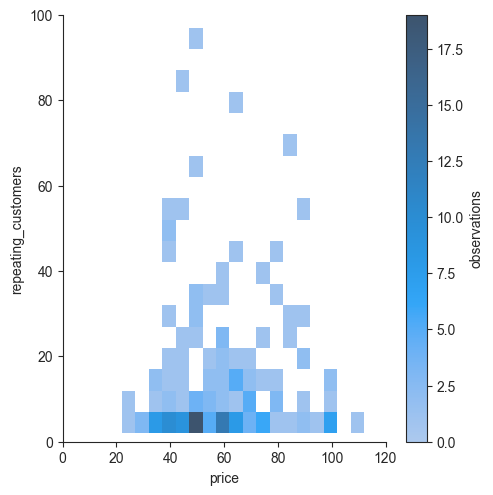

In [11]:
sns.displot(filtered, x="price", y="repeating_customers",binwidth=(5, 5), cbar='True',cbar_kws={'label': 'observations'}, legend= True)
plt.xlim(0, 120)
plt.ylim(0, 100)
plt.savefig('displot_price_rc_'+str(zip_code)+'.png', transparent=False)
plt.show()

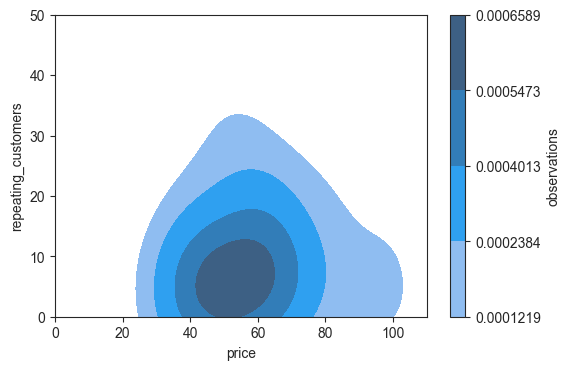

In [12]:
sns.kdeplot(   data= filtered, x="price", y="repeating_customers",  cbar='True',cbar_kws={'label': 'observations'}, fill=True, legend= True,  levels=5, thresh=.2, clip=((0, 110), (0, 50)))
plt.savefig('kdeplot_price_rc_'+str(zip_code)+'.png', transparent=False)
plt.show()